# Training a high-accuracy GNN on graph-level QM9 prediction task

In [2]:
import torch
from torch.nn import Linear
from torch.nn import DataParallel
import torch.nn.functional as functional
import torch_geometric
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.utils import to_networkx, remove_self_loops
from torch_geometric.transforms import ToUndirected, Compose, Distance, OneHotDegree
from torch_geometric.nn import (
    GCNConv,
    ChebConv,
    GraphConv,
    GatedGraphConv,
    NNConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool
)
from sklearn.model_selection import train_test_split

/global/homes/s/sidnb13/.conda/envs/qm9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.get_device_name()

'NVIDIA A100-PCIE-40GB'

In [4]:
torch.cuda.empty_cache()

In [24]:
!nvidia-smi

Sun Oct 23 07:55:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt

Defining parameters

In [7]:
target_class = 10 # Gibbs Free Energy
dim = 64
batch_size = 32
lr = 0.01
degree_radius = 5

## Loading and visualizing data

| Feature | Description |
| :--- | :--- |
| Atom type | H, C, N, O, F (one-hot) |
| Atomic number | Number of protons (integer) |
| Acceptor | Accepts electrons (binary) |
| Donor | Donates electrons (binary) |
| Aromatic | In an aromatic system (binary) |
| Hybridization | sp, sp2, sp3 (one-hot or null) |
| Number of Hydrogens | (integer) |

The one-hot degree transform makes the $(n,11)$ feature matrix (for $n$ nodes and 11 features) into a $(n, 11 + \text{maxdeg})$ size feature matrix by adding a one-hot encoding of each node degrees. The Euclidean distance of linked nodes is also concatenated to the edge attributes.

In [37]:
class TargetTransform(torch_geometric.transforms.BaseTransform):
    def __call__(self, data):
        data.y = data.y[:,target_class]
        return data

In [38]:
composition = Compose([
    Distance(norm=False), 
    OneHotDegree(max_degree=degree_radius, cat=True),
    TargetTransform()
])

In [61]:
dataset = QM9(root='./data', transform=composition)
print('Num graphs', len(dataset))

d = dataset[0]

print('Node features', d.num_node_features)
print('Nodes', d.num_nodes)

print('Edge features', d.num_edge_features)
print('Edge attrs', d.edge_attr.shape)

print('Actual edge attrs: ', d.edge_attr)

Num graphs 130831
Node features 17
Nodes 5
Edge features 5
Edge attrs torch.Size([8, 5])
Actual edge attrs:  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0919]])


Normalizing target data prevents `nan` errors

In [47]:
dymean = dataset.data.y[:,target_class].mean()
dystd = dataset.data.y[:,target_class].std()
print('Mean and std: ', dymean, dystd)
# Before normalization
print('Before normalization : ', dataset.data.y[:,target_class])
# Post normalization
mean = torch.ones(dataset.data.y.shape[1]).scatter_(0, torch.tensor([target_class]), dymean)
std = torch.ones(dataset.data.y.shape[1]).scatter_(0, torch.tensor([target_class]), dystd)

dataset.data.y = (dataset.data.y - mean) / std

print('After normalization: ', dataset.data.y[:,target_class])

Mean and std:  tensor(-11179.8770) tensor(1085.5924)
Before normalization :  tensor([ -1102.0229,  -1538.6667,  -2079.5581,  ..., -10361.6367,
         -9925.3438, -10902.5732])
After normalization:  tensor([9.2833, 8.8811, 8.3828,  ..., 0.7537, 1.1556, 0.2554])


Assumption is bond type means `ionic, covalent, metallic, molecular` so we have 4 dimensions in one-hot plus 1 for the Euclidean distance

In [43]:
def train_test_splits(dataset, train_split=0.8, val_split=0.1):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=1-train_split-val_split)
    train_idx, val_idx = train_test_split(list(range(int(len(dataset) * (1 - val_split)))), test_size=val_split)
    
    return {
        'train': Subset(dataset, train_idx),
        'test': Subset(dataset, test_idx),
        'val': Subset(dataset, val_idx)
    }

In [44]:
splits = train_test_splits(dataset)
train_load, test_load, val_load = [DataLoader(spx, shuffle=False, batch_size=batch_size) for spx in splits.values()]

In [45]:
print(len(train_load), len(test_load), len(val_load)) # Number of batches for each split

3312 409 368


Visualize a molecule

In [53]:
def visualize_molecule(d: torch_geometric.data.data.Data, x: torch.Tensor, edge_attr: torch.Tensor, edge_indices: torch.Tensor, axis=None, viz=True) -> None:
    atom_map = {0:'H', 1:'C', 2:'N', 3:'O', 4:'F'}
    atom_color_map = {'H': 'whitesmoke', 'C': 'gray', 'N': 'red', 'O': 'blue', 'F': 'green'}
    
    atom_encodings = [atom_map[idx.item()] for idx in x[:,:5].argmax(dim=1)]        
    atomic_numbers = x[:,5]
    acceptor = x[:,6]
    donor = x[:,7]
    aromatic = x[:,8]
    hydrogens = x[:,10]
    degrees = x[:,10:]
    
    graph = to_networkx(d)
    
    labels = {}
    for i, node in enumerate(graph.nodes()):
        labels[node] = atom_encodings[i]    
    
    pos = nx.spring_layout(graph)
    
    # color nodes based on atomic basis
    for atom_encoding in set(atom_encodings):
        group = {}
        for i, ac in enumerate(atom_encodings):
            if ac == atom_encoding:
                group[i] = ac
        nx.draw_networkx_nodes(graph,pos,group,node_color=atom_color_map[atom_encoding], ax=axis)
    
    nx.draw_networkx_labels(graph,pos,labels,font_size=14, ax=axis)
    
    edge_pairs = [(k,v) for k,v in zip(*edge_indices.tolist())]
    
    nx.draw_networkx_edges(graph,pos,edge_pairs, ax=axis)
    
    return {
        'atom_encodings': atom_encodings,
        'atomic_numbers': atomic_numbers,
        'acceptor': acceptor,
        'donor': donor,
        'aromatic': aromatic,
        'hydrogens': hydrogens,
        'degrees': degrees
    }


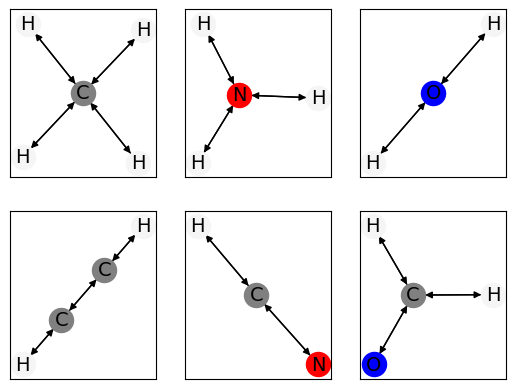

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.flatten()

for i,d in enumerate(dataset[:len(ax)]):
    visualize_molecule(d, d.x, d.edge_attr, d.edge_index, axis=ax[i])

## Creating models

First a simple `GCNConv` based network with 2 convolutional layers and a global mean readout layer for benchmarking.

In [57]:
class SimpleGCNConv(torch.nn.Module):
    def __init__(self, hidden_features) -> None:
        super().__init__()
        
        self.lin1 = Linear(dataset.num_features, hidden_features)
        self.conv1 = GCNConv(hidden_features, hidden_features)
        self.conv2 = GCNConv(hidden_features, hidden_features)
        self.lin2 = Linear(hidden_features, 1)
        
    def forward(self, data: torch_geometric.data.data.Data):
        x, edges = data.x, data.edge_index
        
        # Apply a linear layer to inputs
        x = self.lin1(x)
        x = functional.relu(x)
        
        # Convolutional layers in sequence
        x = self.conv1(x, edges)
        x = functional.relu(x)
        
        x = self.conv2(x, edges)
        x = functional.relu(x)
        
        # print('before', x.shape)
        
        # Apply readout (global pooling layer)
        x = global_mean_pool(x, data.batch)
        
        # print('after', x.shape)
        
        x = self.lin2(x)
        
        return x.view(-1)

Both `NNConv` and `GCN` layers in sequence.

In [65]:
class GCN_NN_Model(torch.nn.Module):
    def __init__(self, hidden_units) -> None:
        super().__init__()
        
        self.lin1 = Linear(dataset.num_features, hidden_units)

        net = torch.nn.Sequential(
            Linear(dataset.num_edge_features, hidden_units * 2),
            torch.nn.ReLU(),
            Linear(hidden_units * 2, hidden_units * hidden_units)
        )
        
        self.conv1 = NNConv(hidden_units, hidden_units, net, aggr='mean')
        self.conv2 = GCNConv(hidden_units, hidden_units)
        self.lin2 = Linear(hidden_units, 1)
    
    def forward(self, data):
        x, edge_idx, edge_attr = data.x, data.edge_index, data.edge_attr
        
        out = self.lin1(x)
        out = functional.relu()
        
        out = self.conv1(out, edge_idx, edge_attr)
        out = functional.relu
        
        out = self.conv2(out, edge_idx)
        out = functional.relu()
        
        # readout
        out = global_mean_pool(out, data.batch)
        
        out = self.lin2(out, 1)
        
        return out.view(-1)

## Training

Seeing which models yield the best results by training each with 50 epochs in sequence.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Defining train and test routines

In [69]:
class Trainer:
    def __init__(model, train_load, test_load, val_load, epochs=50) -> None:
        self.model = model
        self.epochs = epochs
        
        # move model to device
        self.model = self.model.to(device)
        
        self.train_load = train_load
        self.test_load = test_load
        self.val_load = val_load
    
    def train(self):
        self.model.train()
        loss = 0
            
        for batch in self.train_load:
            batch = batch.to(device)
            
            # Reset gradients at start of epoch
            optimizer.zero_grad()
            
            out = self.model(batch)
            
            # Calculate loss and perform backprop
            # print(out, batch.y)
                    
            loss_inter = functional.mse_loss(out, batch.y, reduction='sum')
            loss_inter.backward()
            
            loss += loss_inter.item()
            
            # Perform gradient descent
            optimizer.step()
            
        return loss / len(train_load.dataset)

    def test(self, loader_to_use):
        self.model.eval()
        loss = 0
            
        for batch in loader_to_use:
            batch = batch.to(device)
            out = self.model(batch)
            
            loss_inter = functional.mse_loss(out, batch.y, reduction='sum')
            loss += loss_inter.item()
                    
        return loss / len(loader_to_use.dataset)

    def routine(self):
        self.model.train()

        train_loss, test_loss, val_loss = [], [], []

        for epoch in tqdm(self.epochs):
            trloss = self.train()
            valoss = self.test(self.val_load)
            teloss = self.test(self.test_load)
            
            print(f'EPOCH {epoch}/{self.epochs} | train: {train_loss:>.3f} : test: {test_loss:>.3f} val: {val_loss:>.3f}')
            
            train_loss.append(trloss)
            test_loss.append(teloss)
            val_loss.append(valoss)

        return train_loss, test_loss, val_loss

In [ ]:
basic_gnn_trainer = Trainer(train_load, test_load, val_load)
gnn_nn_trainer = Trainer(train_load, test_load, val_load)

## Evaluation

In [ ]:
def plot_loss(train_loss, test_loss, val_loss):
    plt.figure(0)

    if train_loss is not None:
        plt.plot(train_loss)
        plt.xlabel('Epoch')
        plt.ylabel('MSE Train Loss')

        plt.figure(1)

    if test_loss is not None:
        plt.plot(test_loss, label='Test MSE')
    
    if val_loss is not None:
        plt.plot(val_loss, label='Val MSE')
    
    plt.xlabel('Epoch')
    plt.ylabel('MSE')

    plt.show()

### Baseline models for reference

In [ ]:
mse1, mse2, mse3 = basic_gnn_trainer.routine()
plot_loss(mse1, mse2, mse3)

In [ ]:
mse1, mse2, mse3 = gnn_nn_trainer.routine()
plot_loss(mse1, mse2, mse3)

### Trying out SchNet (SOTA)

In [ ]:
from torch_geometric.nn import SchNet
import os
import ase
import tqdm

In [ ]:
schnet_pretrained, schnet_datasets = SchNet.from_qm9_pretrained('./data', dataset, target_class)
train_schnet, test_schnet, val_schnet = schnet_datasets
schnet_loader = DataLoader(test_schnet, batch_size=128)

In [ ]:
test_loss = []

for data in tqdm(schnet_loader):
    data = data.to(device)
    with torch.no_grad():
        pred = schnet_pretrained(data.z, data.pos, data.batch, data.edge_index)
    mse = functional.mse_loss(pred.view(-1) - data.y[:, target_class]).item()
    test_loss.append(mse)
    
plot_loss(None, test_loss, None)